<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Boundless_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Colab Notebook, we will convert the Boundless model ([Boundless: Generative Adversarial Networks for Image Extension](https://arxiv.org/pdf/1908.07007.pdf)) for image to TensorFlow Lite and will also run inference with the model. The pre-trained model is available via [TensorFlow Hub](https://tfhub.dev/s?q=google%2Fboundless). This Colab Notebook makes use of the following tutorial as a reference - https://www.tensorflow.org/hub/tutorials/boundless.  

## Initial setup


In [1]:
# Model does not work with TensorFlow 2.4 as of December 21, 2020
!pip install -q tf-nightly

     |████████████████████████████████| 399.1MB 42kB/s 
     |████████████████████████████████| 12.2MB 49.9MB/s 
     |████████████████████████████████| 4.0MB 44.6MB/s 
     |████████████████████████████████| 471kB 52.1MB/s 
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0-dev20201222


In [3]:
from PIL import Image

import time
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt

## Utility functions

In [4]:
# Reference: https://www.tensorflow.org/hub/tutorials/boundless

def preprocess_image(image_path):
    pil_image = Image.open(image_path)
    width, height = pil_image.size
    # crop to make the image square
    pil_image = pil_image.crop((0, 0, height, height))
    pil_image = pil_image.resize((257, 257), Image.ANTIALIAS)
    image_unscaled = np.array(pil_image)
    image_np = np.expand_dims(
        image_unscaled.astype(np.float32) / 255., axis=0)
    return image_np

def visualize_output_comparison(img_original, img_masked, img_filled):
  plt.figure(figsize=(24, 12))
  plt.subplot(131)
  plt.imshow((np.squeeze(img_original)))
  plt.title("Original", fontsize=24)
  plt.axis('off')
  plt.subplot(132)
  plt.imshow((np.squeeze(img_masked)))
  plt.title("Masked", fontsize=24)
  plt.axis('off')
  plt.subplot(133)
  plt.imshow((np.squeeze(img_filled)))
  plt.title("Generated", fontsize=24)
  plt.axis('off')
  plt.show()

## Gather test image

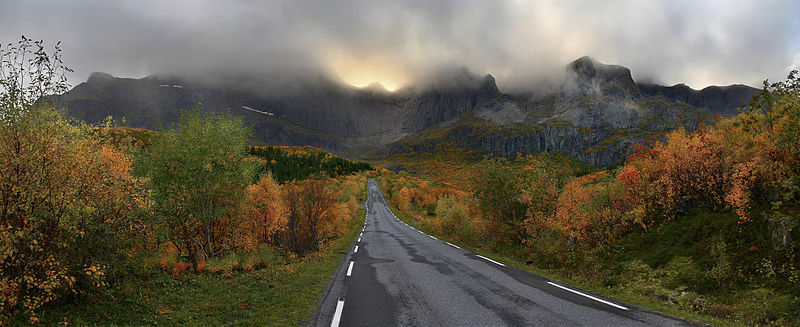

In [5]:
!wget -q -O test_image.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Nusfjord_road%2C_2010_09.jpg/800px-Nusfjord_road%2C_2010_09.jpg
Image.open("test_image.jpg")

In [6]:
#@title Select model variant to convert
model_name = 'Boundless Quarter' # @param ['Boundless Half', 'Boundless Quarter', 'Boundless Three Quarters']
#@markdown The model comes in three different variants with respect to the amount it uses to mask the original image internally - 1/2, 1/4, and 3/4.
model_handle_map = {
    'Boundless Half' : 'https://tfhub.dev/google/boundless/half/1',
    'Boundless Quarter' : 'https://tfhub.dev/google/boundless/quarter/1', 
    'Boundless Three Quarters' : 'https://tfhub.dev/google/boundless/three_quarter/1'
}

model_handle = model_handle_map[model_name]

For [integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant), we need a representative dataset. The Boundless model was primarily trained on the [Places365 dataset](http://places2.csail.mit.edu/). For the quantization purpose, we only need a few images in order to create the representative dataset. So, I prepared a subset of the original training images (50 images) from the Places365 dataset. I used [this notebook](https://colab.research.google.com/gist/sayakpaul/85e0d77ebb780910688436f5ce316efc/scratchpad.ipynb) to do so.  

In [7]:
!wget -q https://storage.googleapis.com/demo-experiments/small_ds_tfrecords.tar.gz
!tar -xf small_ds_tfrecords.tar.gz

We need to write utility functions in order to parse the TFRecords. 

In [8]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [257, 257]) 
    class_label = tf.cast(example['label'], tf.int32)
    
    return image, class_label

def load_dataset(filenames):
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) 
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

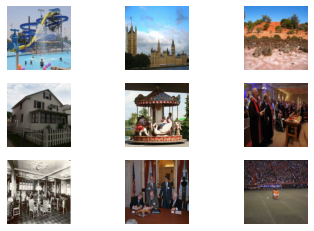

In [9]:
tfrecord_pattern = "/content/small_ds_tfrecords/places365_small-train.tfrecord-*"
train_filenames = tf.io.gfile.glob(tfrecord_pattern)
dataset = load_dataset(train_filenames)
for i, (image, _) in enumerate(dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

Let's now write our representative dataset generator. 

In [11]:
def representative_dataset_gen():
    for image, _ in dataset.take(50):
        image = tf.expand_dims(image, 0)
        yield [image]

In [15]:
#@title Convert to TensorFlow Lite
quantization = 'dr' # @param ['dr', 'float16', 'integer']

# Load the original model
model = hub.load(model_handle)
concrete_function = model.signatures['default']

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_function])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.SELECT_TF_OPS]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="integer":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.SELECT_TF_OPS, 
                                           tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

# Serialize the model
filename = f'boundless_tflite_{quantization}.tflite' 
open(filename, 'wb').write(tflite_model)
print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Model size is 13.346222 MBs.


As we can see the converted (using dynamic-range quantization) model's size is 13.34 MB whereas the original model size is **124.66 MB** (refer [here](https://tfhub.dev/google/boundless/quarter/1)). Here's the full size comparison between different quantization variants - 

In [16]:
!ls -lh *.tflite

-rw-r--r-- 1 root root  14M Dec 23 08:27 boundless_tflite_dr.tflite
-rw-r--r-- 1 root root 6.8M Dec 23 08:26 boundless_tflite_float16.tflite
-rw-r--r-- 1 root root 3.5M Dec 23 08:25 boundless_tflite_integer.tflite


## Running inference

In [55]:
input_img = preprocess_image("test_image.jpg")

### Original model

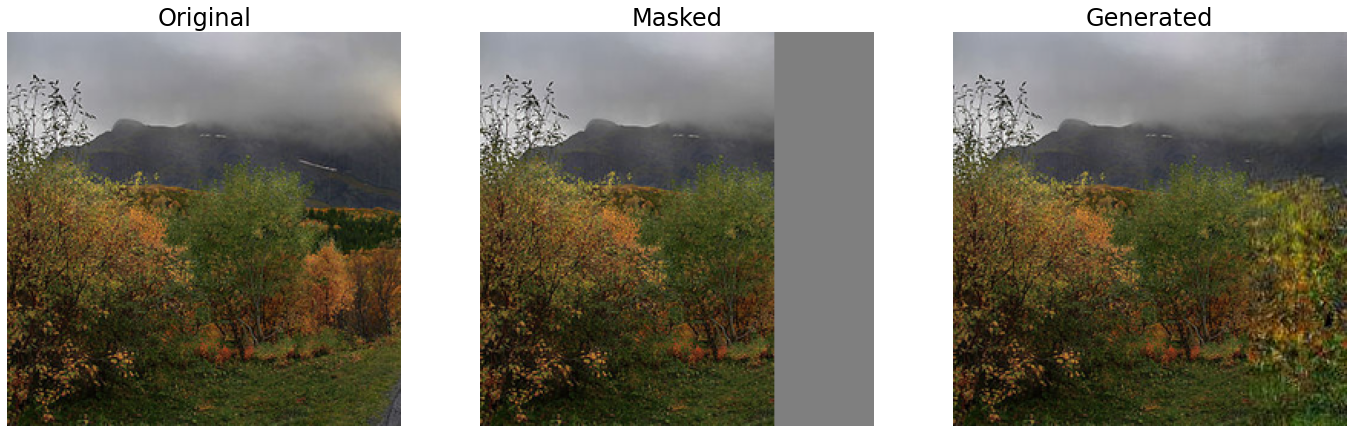

In [56]:
result = model.signatures['default'](tf.constant(input_img))
generated_image =  result['default']
masked_image = result['masked_image']

visualize_output_comparison(input_img, masked_image, generated_image)

### TensorFlow Lite model

In [62]:
#@title Select quantization
quantization = "float16" #@param ["dr", "float16", "integer"]
#@markdown Currently, integer model is erroring out.

interpreter = tf.lite.Interpreter(model_path=f'boundless_tflite_{quantization}.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

if quantization=="integer":
    input_img = preprocess_image("test_image.jpg")
    input_scale, input_zero_point = input_details[0]["quantization"]
    input_img = input_img / input_scale + input_zero_point
    input_img = input_img.astype(input_details[0]["dtype"])

else:
    input_img = preprocess_image("test_image.jpg")

In [63]:
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_img)
start = time.time()
interpreter.invoke()
print(f"Inference took: {time.time()-start} seconds")

Inference took: 1.2660744190216064 seconds


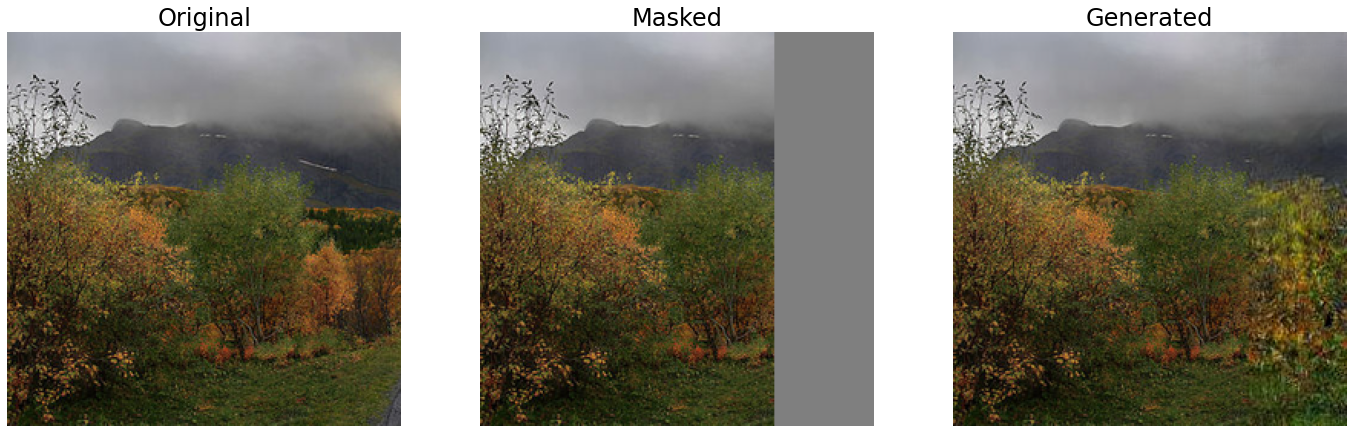

In [64]:
masked_image = interpreter.tensor(interpreter.get_output_details()[1]['index'])()
generated_image = interpreter.tensor(interpreter.get_output_details()[0]['index'])()
visualize_output_comparison(input_img, masked_image, generated_image)

In the following figure (taken from the original paper) we can see some failure cases of the model - 

<p align="center">
<img src="https://i.ibb.co/5cWM31d/Boundless-Failure-Modes.png"></img>
</p>